<a href="https://colab.research.google.com/github/BraedenKuether/Capstone/blob/MLPrototypes/Ashyan's_Copy_of_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

just do 

``` python
pip install pyEX
```
and create a new environment variable 
```
IEX_TOKEN = .....
```


In [ ]:
!pip install pyEX

     |████████████████████████████████| 143kB 8.0MB/s 
     |████████████████████████████████| 788kB 13.7MB/s 
     |████████████████████████████████| 512kB 23.5MB/s 
     |████████████████████████████████| 358kB 11.7MB/s 
     |████████████████████████████████| 204kB 19.1MB/s 
  Created wheel for sseclient: filename=sseclient-0.0.27-cp36-none-any.whl size=5573 sha256=b7df1fb2f1150ce07563936192aebd9ca866408c57c84c106dab835072856cdd
  Stored in directory: /root/.cache/pip/wheels/dc/78/2a/e6a65a58ac19de8ebeff9415501a0eec27b2c99792f67e3808
  Created wheel for frozendict: filename=frozendict-1.2-cp36-none-any.whl size=3149 sha256=10da9c50f9962f43bfa3eb056cbe2b6602e2c7170636db4807bad7c5818d179e
  Stored in directory: /root/.cache/pip/wheels/6c/6c/e9/534386165bd12cf1885582c75eb6d0ffcb321b65c23fe0f834
Successfully built sseclient frozendict
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.8 which is incompatible.
ERROR: google-colab

In [ ]:
import pyEX as p
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as Data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import time

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
def fetchStockData(client, symb, normalize = True):
  '''
  params:
          client: pyEX client object
          symb: string corresponding to stock symbol

  returns:
          tuple of (dayClose,dayReturn) as pyTorch tensors
  '''
  x = client.chartDF(symb,timeframe='5y')
  dayClose = torch.tensor(x['close'].values)
  dayOpen = torch.tensor(x['open'].values)
  dayReturn = dayClose - dayOpen
  
  return dayClose,dayReturn




In [ ]:
NUM_ASSETS = 10
TIME_PERIOD_LENGTH = 30
BATCH_SIZE=64

In [ ]:
def buildTimeSeries(dayClose,dayReturn):
  '''
  params:
         dayClose: tensor of dayClose for 5 years 
         dayReturn: tensor of dayReturn for 5 years
  returns:
         list of tensors each with of shape 30 x 2
  '''
  chunk_amt = int(len(dayClose)/TIME_PERIOD_LENGTH)
  catted = torch.cat((dayClose.reshape(1,-1),dayReturn.reshape(1,-1))).T
  #asset_flipped = torch.stack(torch.flip(catted,[0]).chunk(chunk_amt)[:-1])
  return catted

# **Pre-Processing Data**

In [ ]:
#Non-Overlapping Batches

class PortfolioDataSet(Dataset):
  # assumes 5 year history for all assets need to generalize eventually
  def __init__(self,data, window, batch = True):
    '''
      params:
             data: list of list of tensors [[T]]
                   i.e data[i] = the entire history for the ith asset
                       data[i][j] = the ith assests jth data point
    '''
    self.assets = data
    self.n = len(data) # num assets in portfolio
    self.window = window
    self.data = []
    self.non_normal_data = []
    scaler = MinMaxScaler()
    for i in range(len(self.assets[0]) - self.window + 1):
      select = []
      for day in range(self.window):
        curr_time = []
        for asset in range(self.n):
          curr_time.append(self.assets[asset][day + i][0].item())
          curr_time.append(self.assets[asset][day + i][1].item())
        select.append(curr_time)
      scaler.fit(select)
      normalized = scaler.transform(select)
      self.non_normal_data.append(select)
      self.data.append(normalized)

    self.non_normal_data = torch.Tensor(self.non_normal_data)
    if batch:
      #self.data = torch.split(torch.Tensor(self.data),BATCH_SIZE)
      self.data = torch.split(torch.Tensor(self.non_normal_data),BATCH_SIZE)

  def __len__(self):
   return len(self.data)
  
  def __getitem__(self,idx):
    '''
      params:
            idx: index for ith data point
      returns:
            tensor represeting a single input example
            formed by concatenating the ith data point from 
            each asset. Should be of shape (TIME_PERIOD_LENGTH,2 x self.n)
    '''
    return self.data[idx]
  def non_normal(self):
    return self.non_normal_data

  def shuffle(self):
    temp = list(zip(self.data, self.non_normal_data)) 
    random.shuffle(temp) 
    temp_data, temp_non_normal = zip(*temp)
    self.data,self.temp_non_normal = list(temp_data),list(temp_non_normal)
    


In [ ]:
"""
class PortfolioDataSet(Dataset):
  # assumes 5 year history for all assets need to generalize eventually
  def __init__(self,data, window):
    '''
      params:
             data: list of list of tensors [[T]]
                   i.e data[i] = the entire history for the ith asset
                       data[i][j] = the ith assests jth data point
    '''
    self.assets = data
    self.n = len(data) # num assets in portfolio
    self.window = window

    reached_end = False
    idx = 0
    self.data = []
    self.non_normal_data = []
    scaler = MinMaxScaler()
    while reached_end==False:
      data_window = []
      non_normal = []
      for i in range(self.window):
        select = []
        if idx + TIME_PERIOD_LENGTH - 1 + i < len(self.assets[0]):
          for day in range(TIME_PERIOD_LENGTH):
              curr_time = []
              for asset in range(self.n):
                curr_time.append(self.assets[asset][idx + day + i][0].item())
                curr_time.append(self.assets[asset][idx + day + i][1].item())
              select.append(curr_time)
          
          scaler.fit(select)
          normalized = scaler.transform(select)
          non_normal.append(select)
          data_window.append(normalized)
        else:
            reached_end = True
            break 
      idx += 1
      if reached_end == False:
        self.data.append(torch.Tensor(data_window).view(self.window,TIME_PERIOD_LENGTH,NUM_ASSETS*2))
        self.non_normal_data.append(torch.Tensor(non_normal).view(self.window,TIME_PERIOD_LENGTH,NUM_ASSETS*2))

  def __len__(self):
   return len(self.data)
  
  def __getitem__(self,idx):
    '''
      params:
            idx: index for ith data point
      returns:
            tensor represeting a single input example
            formed by concatenating the ith data point from 
            each asset. Should be of shape (TIME_PERIOD_LENGTH,2 x self.n)
    '''
    return self.data[idx]
  def non_normal(self):
    return self.non_normal_data

  def shuffle(self):
    temp = list(zip(self.data, self.non_normal_data)) 
    random.shuffle(temp) 
    temp_data, temp_non_normal = zip(*temp)
    self.data,self.temp_non_normal = list(temp_data),list(temp_non_normal)
"""

"\nclass PortfolioDataSet(Dataset):\n  # assumes 5 year history for all assets need to generalize eventually\n  def __init__(self,data, window):\n    '''\n      params:\n             data: list of list of tensors [[T]]\n                   i.e data[i] = the entire history for the ith asset\n                       data[i][j] = the ith assests jth data point\n    '''\n    self.assets = data\n    self.n = len(data) # num assets in portfolio\n    self.window = window\n\n    reached_end = False\n    idx = 0\n    self.data = []\n    self.non_normal_data = []\n    scaler = MinMaxScaler()\n    while reached_end==False:\n      data_window = []\n      non_normal = []\n      for i in range(self.window):\n        select = []\n        if idx + TIME_PERIOD_LENGTH - 1 + i < len(self.assets[0]):\n          for day in range(TIME_PERIOD_LENGTH):\n              curr_time = []\n              for asset in range(self.n):\n                curr_time.append(self.assets[asset][idx + day + i][0].item())\n        

In [ ]:
IEX_TOKEN = "Tpk_647cd93d6c5842d6978e55c6f79b0e1a"

client = p.Client(api_token = IEX_TOKEN, version='sandbox')

#stonks = ['amd','wfc','ge','aapl','aal','hog','f','bac','t','intc']
stonks = ['vti', 'agg', 'dbc', 'vixy']
NUM_ASSETS = len(stonks)
training_data = []
testing_data = []
i = 0
for symb in stonks:
  c,r = fetchStockData(client,symb)
  s = buildTimeSeries(c,r)
  len_data = len(s)
  training_data.append(s[:int(0.9*len_data)])
  testing_data.append(s[int(0.9*len_data):])
  i += 1


d = PortfolioDataSet(training_data,TIME_PERIOD_LENGTH)
testing_d = PortfolioDataSet(testing_data,TIME_PERIOD_LENGTH)

In [ ]:
print(len(d))
print(len(testing_d))
print(d[0].shape)
print(d[1].shape)
print(d[-1].shape)

18
2
torch.Size([64, 30, 8])
torch.Size([64, 30, 8])
torch.Size([16, 30, 8])


# **Building the Net With Batching Input Data and Iterating over All Batches Each Epoch**

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input = nn.LSTM(NUM_ASSETS * 2, NUM_ASSETS, 1, batch_first = True)
        self.lin = nn.Linear(TIME_PERIOD_LENGTH * NUM_ASSETS,NUM_ASSETS)
        self.soft_out = nn.Softmax(dim=1)
    def forward(self, x, batch_len):
        x, (h0, c0) = self.input(x)
        #print(x.shape)
        x = x.reshape(batch_len, TIME_PERIOD_LENGTH * NUM_ASSETS)
        #print(x[0],x[1])
        #print(x.shape)
        x = self.lin(x)
        #print(x[0],x[1])
        #print(x)
        x = self.soft_out(x)
        return x

In [ ]:

def sharpe_loss(weights, batch_pos, batch_len):
  total_ratio = 0
  returns = d.non_normal()[batch_pos]
  total_ratio = 0
  er = 0
  er2 = 0
  for seq in range(1, batch_len):
    month_data = returns[seq]
    r_i_t = (month_data[TIME_PERIOD_LENGTH - 1].reshape(NUM_ASSETS,2)[:,0]/(month_data[0].reshape(NUM_ASSETS,2)[:,0] - month_data[0].reshape(NUM_ASSETS,2)[:,1])) - 1
    #print("month_data", month_data[TIME_PERIOD_LENGTH - 1].reshape(NUM_ASSETS,2)[:,0], month_data[0].reshape(NUM_ASSETS,2)[:,0] - month_data[0].reshape(NUM_ASSETS,2)[:,1])
    #print("day close/returns:", month_data[0].reshape(NUM_ASSETS,2)[:,0], month_data[0].reshape(NUM_ASSETS,2)[:,1])
    #print("r_i_t", r_i_t)
    #print(r_i_t.shape)
    curr_er = torch.dot(r_i_t, weights[seq - 1])
    er += curr_er
    er2 += curr_er**2
    """
    month_return = month_return/torch.reshape(d[time_period - 1][-1],(NUM_ASSETS,2))[:,0]
    
    er += torch.dot(weights,month_return)
    er2 += torch.dot(weights,month_return)**2
    er_std += torch.std(torch.mul(weights,month_return))
    total_return_by_asset += torch.mul(weights,month_return)
    """
  er = er/(batch_len - 1)
  """
  for day in range(TIME_PERIOD_LENGTH):
    curr_er2 = 0
    for asset in range (NUM_ASSETS):
      curr_er2 += out[asset][day][0] * d[TIME_PERIOD_LENGTH][asset][day][1]
    er2 += curr_er2**2
  er2 = er2/TIME_PERIOD_LENGTH
  """
  #print("er:", er, "er_std:", er_std)
  #ratio = er / er_std
  ratio = er / torch.sqrt(er2 - er**2)
  #ratio = er / torch.std(total_return_by_asset)
  ratio = -1 * ratio
  return ratio

In [ ]:
#Testing the Sharpe Ratio
"""
example_weights = [0.1] * 10
returns = d[0][0]
return_count = 0
return_total = 0
for day in range(1, len(torch.reshape(returns, (30, 10, 2)))):
  return_total += torch.reshape(returns[day], (10,2))[:,1]/torch.reshape(returns[day - 1], (10,2))[:,0]
  return_count += 1

reshaped = torch.reshape(returns, (30, 10, 2))
print(reshaped[1])
print(reshaped[1:][:,:,1][0])
print((return_total/return_count))
"""

'\nexample_weights = [0.1] * 10\nreturns = d[0][0]\nreturn_count = 0\nreturn_total = 0\nfor day in range(1, len(torch.reshape(returns, (30, 10, 2)))):\n  return_total += torch.reshape(returns[day], (10,2))[:,1]/torch.reshape(returns[day - 1], (10,2))[:,0]\n  return_count += 1\n\nreshaped = torch.reshape(returns, (30, 10, 2))\nprint(reshaped[1])\nprint(reshaped[1:][:,:,1][0])\nprint((return_total/return_count))\n'

In [ ]:
net = Net()
net.cuda()
total_r = 0
total_r2 = 0
num_epochs = 100
losses = []
returns = []
outs = []
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_fn = sharpe_loss
for epoch in range(num_epochs):
  #d.shuffle()
  for i in range(len(d)):
    #print("d[i]",d[i])
    #print(d[i].shape)
    out = net.forward(d[i], len(d[i]))
    if epoch == num_epochs - 1:
      outs.append(out)
    #print(out)
    #print(out.shape)
    #print("weights: ", out)
    #print("shape:", out.shape)
    loss = loss_fn(out, i, len(d[i]))
    losses.append(loss.item())
    print("epoch {} step {} loss:".format(epoch, i), loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


print(out)
"""
for asset in out:
  weights.append(asset[-1][0].item())
print(weights)
"""

IndexError: ignored

In [ ]:
def plotReturns(cash,weights,T,batchSize):
    r = returns[:,T:T+batchSize]
    r = torch.transpose(r,0,1)
    R = torch.mul(weights,r)
    R = cash*R
    R = R+cash*weights
    R = torch.sum(R,1)
    print(torch.mean(R))
    plt.plot(R.numpy())

returns = []
ctr = 0
for i,batch in enumerate(reversed(outs)):
  if ctr % 64 == 0:
    returns.append(torch.dot(batch, ))
    ctr = 0

  ctr += 1

#w = torch.tensor([0.2174, 0.0106, 0.0102, 0.3545, 0.0112, 0.0398, 0.0179, 0.1410, 0.0906,
#         0.1069]).reshape(1,10)


#plotReturns(1000,outs,0,64)

In [ ]:
import matplotlib

In [ ]:
x = [i for i in range(len(losses))]
matplotlib.pyplot.plot(x,losses)
matplotlib.pyplot.show()

In [ ]:
losses = []
with torch.no_grad():
  for i in range(len(testing_d)):
    #print("d[i]",d[i])
    #print(d[i].shape)
    out = net.forward(testing_d[i], len(testing_d[i]))
    if epoch == num_epochs - 1:
      outs.append(out)
    #print(out)
    #print(out.shape)
    #print("weights: ", out)
    #print("shape:", out.shape)
    loss = loss_fn(out, i, len(testing_d[i]))
    losses.append(loss.item())
    print("epoch {} step {} loss:".format(epoch, i), loss.item())
x = [i for i in range(len(losses))]
matplotlib.pyplot.plot(x,losses)
matplotlib.pyplot.show()

In [ ]:
losses_avgd = []
for i in range(100):
  losses_avgd.append(sum(losses[i*len(d):len(d)*(i+1)])/len(d))

x = [i for i in range(len(losses_avgd))]
matplotlib.pyplot.plot(x,losses_avgd)
matplotlib.pyplot.show()

# **Building the Net Without Batching Input Data and Iterating Over Each Data Point Epoch Amount of Times**

## **Hyper Parameter Tuning**


Parameters are Formmated as (TIME_PERIOD_LENGTH, BATCH_SIZE, epochs)

In [ ]:
from collections import defaultdict

In [ ]:
#params = [(30, 30), (45,30), (60,30), (30, 60), (45, 60), (60, 60)]
params = []
time_lengths = [30,45,60]
batches = [30,60]
epochs = [10,25,50,75,100,125,150,175,200]
for time_len in time_lengths:
  for batch in batches:
    for epoch in epochs:
      params.append((time_len, batch, epoch))
results = defaultdict(list)

In [ ]:
for param in params:
  for _ in range(10):
    TIME_PERIOD_LENGTH, BATCH_SIZE, num_epochs = param
    print(TIME_PERIOD_LENGTH, BATCH_SIZE)
    IEX_TOKEN = "Tpk_647cd93d6c5842d6978e55c6f79b0e1a"

    client = p.Client(api_token = IEX_TOKEN, version='sandbox')
    #testing_len = 0
    #stonks = ['amd','wfc','ge','aapl','aal','hog','f','bac','t','intc']
    stonks = ['vti', 'agg', 'dbc', 'vixy']
    NUM_ASSETS = len(stonks)
    training_data = []
    testing_data = []
    i = 0
    for symb in stonks:
      c,r = fetchStockData(client,symb)
      s = buildTimeSeries(c,r)
      len_data = len(s)
      print(len_data)
      #testing_data.append(s[-testing_len:])
      #training_data.append(s[:-testing_len])
      training_data.append(s)
      i += 1


    d = PortfolioDataSet(training_data,TIME_PERIOD_LENGTH, batch = True)
    #testing_d = PortfolioDataSet(testing_data,TIME_PERIOD_LENGTH, batch = False)
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.input = nn.LSTM(NUM_ASSETS * 2, 64, 1, batch_first = True)
            self.lin = nn.Linear(TIME_PERIOD_LENGTH * 64,NUM_ASSETS)
            self.soft_out = nn.Softmax(dim=1)
        def forward(self, x, batch_len):
            x, (h0, c0) = self.input(x)
            #print(x.shape)
            x = x.reshape((batch_len, TIME_PERIOD_LENGTH * 64))
            #print(x[0],x[1])
            #print(x.shape)
            x = self.lin(x)
            #print(x[0],x[1])
            #print(x)
            x = self.soft_out(x)
            return x
    def sharpe_loss(weights, batch_pos, batch_len):
      total_ratio = 0
      total_ratio = 0
      er = 0
      er2 = 0
      for batch in range(batch_len):
        month_data = d.non_normal()[BATCH_SIZE * batch_pos + batch].view(TIME_PERIOD_LENGTH, NUM_ASSETS, 2)[:,:,0]
        future_month_data = d.non_normal()[BATCH_SIZE * batch_pos + batch + TIME_PERIOD_LENGTH].view(TIME_PERIOD_LENGTH, NUM_ASSETS, 2)[:,:,0]
        r_i_t = future_month_data[-1]/month_data[-1] - 1
        #print("month_data", month_data[TIME_PERIOD_LENGTH - 1].reshape(NUM_ASSETS,2)[:,0], month_data[0].reshape(NUM_ASSETS,2)[:,0] - month_data[0].reshape(NUM_ASSETS,2)[:,1])
        #print("day close/returns:", month_data[0].reshape(NUM_ASSETS,2)[:,0], month_data[0].reshape(NUM_ASSETS,2)[:,1])
        #print("r_i_t", r_i_t)
        #print(r_i_t.shape)
        curr_er = torch.dot(r_i_t, weights[batch])
        er += curr_er
        er2 += curr_er**2
        """
        month_return = month_return/torch.reshape(d[time_period - 1][-1],(NUM_ASSETS,2))[:,0]
        
        er += torch.dot(weights,month_return)
        er2 += torch.dot(weights,month_return)**2
        er_std += torch.std(torch.mul(weights,month_return))
        total_return_by_asset += torch.mul(weights,month_return)
        """
      er = er/(batch_len - 1)
      """
      for day in range(TIME_PERIOD_LENGTH):
        curr_er2 = 0
        for asset in range (NUM_ASSETS):
          curr_er2 += out[asset][day][0] * d[TIME_PERIOD_LENGTH][asset][day][1]
        er2 += curr_er2**2
      er2 = er2/TIME_PERIOD_LENGTH
      """
      #print("er:", er, "er_std:", er_std)
      #ratio = er / er_std
      ratio = er / torch.sqrt(er2 - er**2)
      #ratio = er / torch.std(total_return_by_asset)
      ratio = -1 * ratio
      return ratio


    overall_val = 1
    start_day = 0
    net = Net().to('cuda')
    losses_new_net = []
    #num_epochs = 1000
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    loss_fn = sharpe_loss
    total_time = 0
    for i in range(len(d)):
      start = time.time()
      #print(BATCH_SIZE * i + len(d[i] - 1))
      print("step {}".format(i))
      if BATCH_SIZE * i + (len(d[i]) - 1) + TIME_PERIOD_LENGTH < len(d.non_normal()):
        for epoch in range(num_epochs):
          out = net.forward(d[i], len(d[i]))
          non_normal_index = i * BATCH_SIZE
          if epoch == 0 and non_normal_index + 2*TIME_PERIOD_LENGTH < len(d.non_normal()):
            weights = out[0].view(NUM_ASSETS)
            close = torch.Tensor(d.non_normal()[non_normal_index + TIME_PERIOD_LENGTH][-1].view(NUM_ASSETS,2)[:,0])
            next_close = torch.Tensor(d.non_normal()[non_normal_index + 2*TIME_PERIOD_LENGTH][-1].view(NUM_ASSETS,2)[:,0])
            percent_change = torch.dot((next_close/close - 1), weights)
            overall_val *= (1 + percent_change)
            #if BATCH_SIZE == 60:
            #  weights = out[TIME_PERIOD_LENGTH].view(NUM_ASSETS)
            #  non_normal_index = i * BATCH_SIZE + TIME_PERIOD_LENGTH
            #  close = torch.Tensor(d.non_normal()[non_normal_index][-1].view(NUM_ASSETS,2)[:,0])
            #  next_close = torch.Tensor(d.non_normal()[non_normal_index + TIME_PERIOD_LENGTH][-1].view(NUM_ASSETS,2)[:,0])
            #  percent_change = torch.dot((next_close/close - 1), weights)
            #  overall_val *= (1 + percent_change)
            print(overall_val)
          #if epoch == 0 and i > 0:
          #  predicted_weights = out[-1]
          #  close_price = d.non_normal()[37*i]
          loss = loss_fn(out, i, len(d[i]))
          losses_new_net.append(loss.item())
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      else:
        break
      total_time += time.time() - start
      avg_time = total_time/(i + 1)
      print("eta: {}m {}s".format(int(avg_time/60 * (len(d) - i - 1)), int((avg_time * (len(d) - i - 1)) % 60 )))

    print(overall_val)
    results[param].append(overall_val.item())
print(results)

Streaming output truncated to the last 5000 lines.
step 12
tensor(1.1626, grad_fn=<MulBackward0>)
eta: 0m 3s
step 13
tensor(1.2243, grad_fn=<MulBackward0>)
eta: 0m 3s
step 14
tensor(1.2780, grad_fn=<MulBackward0>)
eta: 0m 2s
step 15
tensor(1.1308, grad_fn=<MulBackward0>)
eta: 0m 2s
step 16
tensor(1.2410, grad_fn=<MulBackward0>)
eta: 0m 1s
step 17
tensor(1.3733, grad_fn=<MulBackward0>)
eta: 0m 1s
step 18
eta: 0m 0s
step 19
tensor(1.3733, grad_fn=<MulBackward0>)
60 60
1259
1259
1259
1259
step 0
tensor(0.9044, grad_fn=<MulBackward0>)
eta: 0m 10s
step 1
tensor(0.9088, grad_fn=<MulBackward0>)
eta: 0m 9s
step 2
tensor(0.9684, grad_fn=<MulBackward0>)
eta: 0m 9s
step 3
tensor(0.9756, grad_fn=<MulBackward0>)
eta: 0m 8s
step 4
tensor(0.9901, grad_fn=<MulBackward0>)
eta: 0m 8s
step 5
tensor(1.0178, grad_fn=<MulBackward0>)
eta: 0m 7s
step 6
tensor(1.0956, grad_fn=<MulBackward0>)
eta: 0m 7s
step 7
tensor(1.0932, grad_fn=<MulBackward0>)
eta: 0m 6s
step 8
tensor(1.1037, grad_fn=<MulBackward0>)
eta: 0

## **Regular Training**

In [ ]:
import time

In [ ]:
TIME_PERIOD_LENGTH = 30
BATCH_SIZE = 30

In [ ]:
IEX_TOKEN = "Tpk_647cd93d6c5842d6978e55c6f79b0e1a"

client = p.Client(api_token = IEX_TOKEN, version='sandbox')
testing_len = 91
#stonks = ['amd','wfc','ge','aapl','aal','hog','f','bac','t','intc']
stonks = ['vti', 'agg', 'dbc', 'vixy']
NUM_ASSETS = len(stonks)
training_data = []
testing_data = []
i = 0
for symb in stonks:
  c,r = fetchStockData(client,symb)
  s = buildTimeSeries(c,r)
  len_data = len(s)
  print(len_data)
  testing_data.append(s[-testing_len:])
  training_data.append(s[:-testing_len])
  #testing_data.append(s[int(0.9*len_data):])
  i += 1


d = PortfolioDataSet(training_data,TIME_PERIOD_LENGTH, batch = True)
testing_d = PortfolioDataSet(testing_data,TIME_PERIOD_LENGTH, batch = False)

1259
1259
1259
1259


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input = nn.LSTM(NUM_ASSETS * 2, 64, 1, batch_first = True)
        self.lin = nn.Linear(TIME_PERIOD_LENGTH * 64,NUM_ASSETS)
        self.soft_out = nn.Softmax(dim=1)
    def forward(self, x, batch_len):
        x, (h0, c0) = self.input(x)
        #print(x.shape)
        x = x.reshape((batch_len, TIME_PERIOD_LENGTH * 64))
        #print(x[0],x[1])
        #print(x.shape)
        x = self.lin(x)
        #print(x[0],x[1])
        #print(x)
        x = self.soft_out(x)
        return x

In [ ]:
def sharpe_loss(weights, batch_pos, batch_len):
  total_ratio = 0
  total_ratio = 0
  er = 0
  er2 = 0
  for batch in range(batch_len):
    month_data = d.non_normal()[BATCH_SIZE * batch_pos + batch].view(TIME_PERIOD_LENGTH, NUM_ASSETS, 2)[:,:,0]
    future_month_data = d.non_normal()[BATCH_SIZE * batch_pos + batch + TIME_PERIOD_LENGTH].view(TIME_PERIOD_LENGTH, NUM_ASSETS, 2)[:,:,0]
    r_i_t = future_month_data[-1]/month_data[-1] - 1
    #print("month_data", month_data[TIME_PERIOD_LENGTH - 1].reshape(NUM_ASSETS,2)[:,0], month_data[0].reshape(NUM_ASSETS,2)[:,0] - month_data[0].reshape(NUM_ASSETS,2)[:,1])
    #print("day close/returns:", month_data[0].reshape(NUM_ASSETS,2)[:,0], month_data[0].reshape(NUM_ASSETS,2)[:,1])
    #print("r_i_t", r_i_t)
    #print(r_i_t.shape)
    curr_er = torch.dot(r_i_t, weights[batch])
    er += curr_er
    er2 += curr_er**2
    """
    month_return = month_return/torch.reshape(d[time_period - 1][-1],(NUM_ASSETS,2))[:,0]
    
    er += torch.dot(weights,month_return)
    er2 += torch.dot(weights,month_return)**2
    er_std += torch.std(torch.mul(weights,month_return))
    total_return_by_asset += torch.mul(weights,month_return)
    """
  er = er/(batch_len - 1)
  """
  for day in range(TIME_PERIOD_LENGTH):
    curr_er2 = 0
    for asset in range (NUM_ASSETS):
      curr_er2 += out[asset][day][0] * d[TIME_PERIOD_LENGTH][asset][day][1]
    er2 += curr_er2**2
  er2 = er2/TIME_PERIOD_LENGTH
  """
  #print("er:", er, "er_std:", er_std)
  #ratio = er / er_std
  ratio = er / torch.sqrt(er2 - er**2)
  #ratio = er / torch.std(total_return_by_asset)
  ratio = -1 * ratio
  return ratio

In [ ]:

overall_val = 1
start_day = 0
net = Net().to('cuda')
losses_new_net = []
num_epochs = 100
optimizer = optim.Adam(net.parameters(), lr=1e-4)
loss_fn = sharpe_loss
total_time = 0
for i in range(len(d)):
  start = time.time()
  #print(BATCH_SIZE * i + len(d[i] - 1))
  print("step {}".format(i))
  if BATCH_SIZE * i + (len(d[i]) - 1) + TIME_PERIOD_LENGTH < len(d.non_normal()):
    for epoch in range(num_epochs):
      out = net.forward(d[i], len(d[i]))
      non_normal_index = i * BATCH_SIZE
      if epoch == 0 and non_normal_index + 2*TIME_PERIOD_LENGTH < len(d.non_normal()):
        weights = out[0].view(NUM_ASSETS)
        close = torch.Tensor(d.non_normal()[non_normal_index + TIME_PERIOD_LENGTH][-1].view(NUM_ASSETS,2)[:,0])
        next_close = torch.Tensor(d.non_normal()[non_normal_index + 2*TIME_PERIOD_LENGTH][-1].view(NUM_ASSETS,2)[:,0])
        percent_change = torch.dot((next_close/close - 1), weights)
        overall_val *= (1 + percent_change)
        #if BATCH_SIZE == 60:
        #  weights = out[TIME_PERIOD_LENGTH].view(NUM_ASSETS)
        #  non_normal_index = i * BATCH_SIZE + TIME_PERIOD_LENGTH
        #  close = torch.Tensor(d.non_normal()[non_normal_index][-1].view(NUM_ASSETS,2)[:,0])
        #  next_close = torch.Tensor(d.non_normal()[non_normal_index + TIME_PERIOD_LENGTH][-1].view(NUM_ASSETS,2)[:,0])
        #  percent_change = torch.dot((next_close/close - 1), weights)
        #  overall_val *= (1 + percent_change)
        print(overall_val)
      #if epoch == 0 and i > 0:
      #  predicted_weights = out[-1]
      #  close_price = d.non_normal()[37*i]
      loss = loss_fn(out, i, len(d[i]))
      losses_new_net.append(loss.item())
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  else:
    break
  total_time += time.time() - start
  avg_time = total_time/(i + 1)
  print("eta: {}m {}s".format(int(avg_time/60 * (len(d) - i - 1)), int((avg_time * (len(d) - i - 1)) % 60 )))

print(overall_val)

step 0
tensor(1.0377, grad_fn=<MulBackward0>)
eta: 0m 56s
step 1
tensor(1.0563, grad_fn=<MulBackward0>)
eta: 0m 48s
step 2
tensor(1.1285, grad_fn=<MulBackward0>)
eta: 0m 44s
step 3
tensor(1.1646, grad_fn=<MulBackward0>)
eta: 0m 43s
step 4
tensor(1.2048, grad_fn=<MulBackward0>)
eta: 0m 40s
step 5
tensor(1.2201, grad_fn=<MulBackward0>)
eta: 0m 39s
step 6
tensor(1.1857, grad_fn=<MulBackward0>)
eta: 0m 37s
step 7
tensor(1.2636, grad_fn=<MulBackward0>)
eta: 0m 35s
step 8
tensor(1.2691, grad_fn=<MulBackward0>)
eta: 0m 34s
step 9
tensor(1.3104, grad_fn=<MulBackward0>)
eta: 0m 32s
step 10
tensor(1.2851, grad_fn=<MulBackward0>)
eta: 0m 31s
step 11
tensor(1.3395, grad_fn=<MulBackward0>)
eta: 0m 29s
step 12
tensor(1.3698, grad_fn=<MulBackward0>)
eta: 0m 28s
step 13
tensor(1.3527, grad_fn=<MulBackward0>)
eta: 0m 27s
step 14
tensor(1.3853, grad_fn=<MulBackward0>)
eta: 0m 26s
step 15
tensor(1.4307, grad_fn=<MulBackward0>)
eta: 0m 24s
step 16
tensor(1.4329, grad_fn=<MulBackward0>)
eta: 0m 23s
step 17

In [ ]:
#print(out)

overall_val = 1
start_day = 0
while start_day < len(testing_d):
  with torch.no_grad():
    close = torch.Tensor(testing_d.non_normal()[start_day][-1].view(NUM_ASSETS,2)[:,0])
    if start_day > 0:
      print(weights, close/previous_close - 1)
      percent_change = torch.dot((close/previous_close - 1), weights)
      overall_val *= (1 + percent_change)
    month = torch.Tensor(testing_d[start_day]).view(1,TIME_PERIOD_LENGTH,NUM_ASSETS*2)
    weights = net.forward(month, 1).view(NUM_ASSETS)
    previous_close = close
    start_day += 30
    
print(overall_val)

tensor([0.4545, 0.2161, 0.2333, 0.0961]) tensor([-0.0294,  0.0050, -0.0334, -0.0747])
tensor([0.4467, 0.2182, 0.2374, 0.0976]) tensor([ 0.0497,  0.0188,  0.0096, -0.1914])
tensor(0.9824)


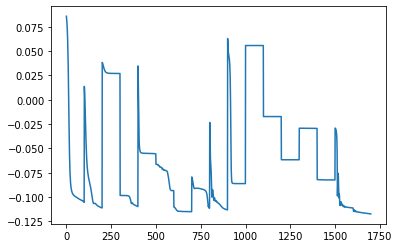

17.0


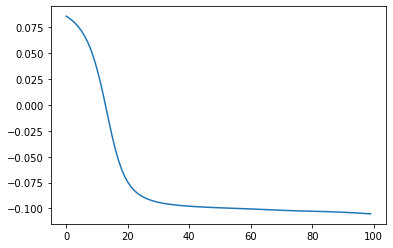

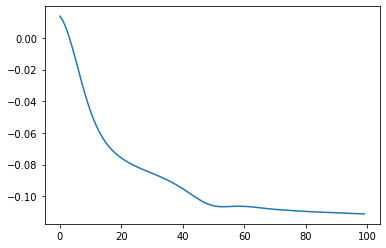

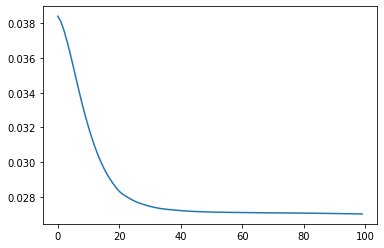

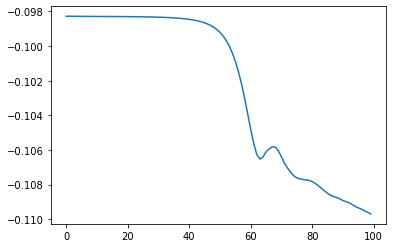

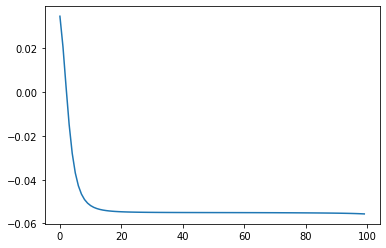

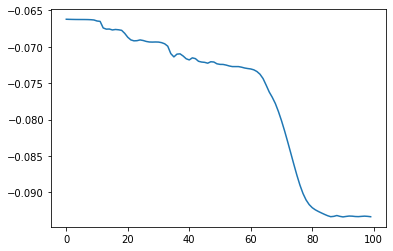

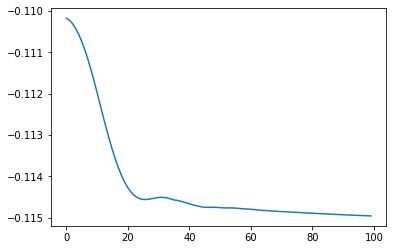

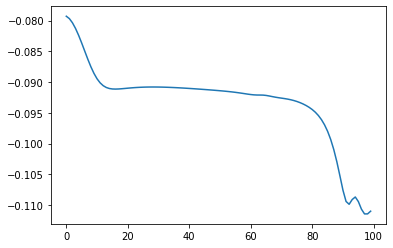

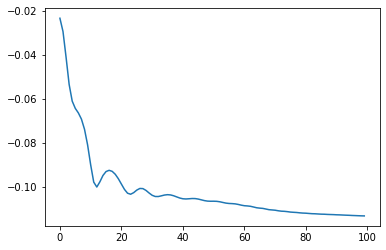

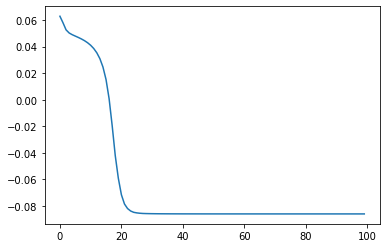

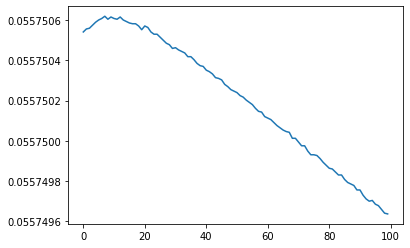

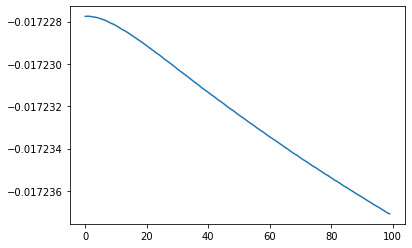

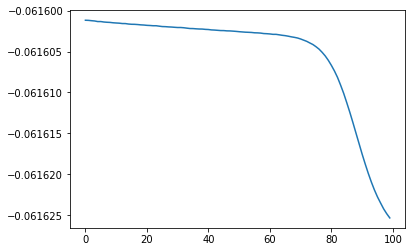

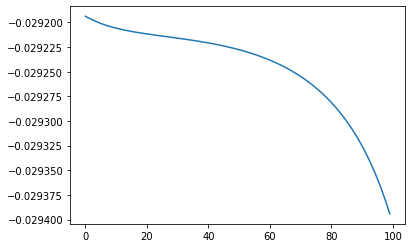

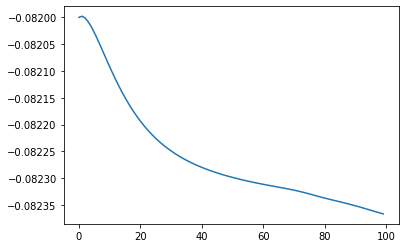

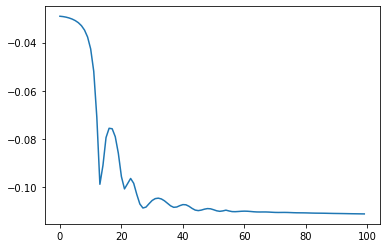

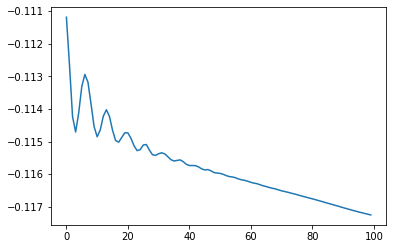

In [ ]:
import matplotlib
x = [i for i in range(len(losses_new_net))]
matplotlib.pyplot.plot(x,losses_new_net)
matplotlib.pyplot.show()
print(len(x)/num_epochs)
for i in range(int(len(x)/num_epochs)):
  x = [i for i in range(len(losses_new_net[i*num_epochs:(i+1)*num_epochs]))]
  matplotlib.pyplot.plot(x,losses_new_net[i*num_epochs:(i+1)*num_epochs])
  matplotlib.pyplot.show()

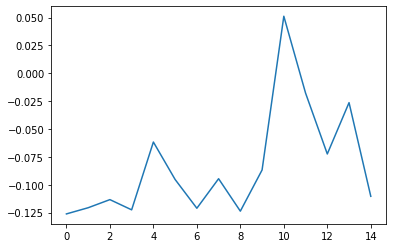

In [ ]:
losses_new_avgd = []
for i in range(int(len(losses_new_net)/num_epochs)):
  losses_new_avgd.append(losses_new_net[num_epochs*(i+1) - 1])

x = [i for i in range(len(losses_new_avgd))]
matplotlib.pyplot.plot(x,losses_new_avgd)
matplotlib.pyplot.show()

1
tensor([0.7553, 0.1434, 0.0472, 0.0541]) tensor([ 0.1185,  0.0055,  0.0614, -0.1591])
tensor(1.0619)
tensor([0.7570, 0.1223, 0.0507, 0.0700]) tensor([0.0097, 0.0014, 0.0383, 0.0315])
tensor(1.1401)
tensor([0.7985, 0.1080, 0.0375, 0.0561]) tensor([ 0.1180,  0.0167,  0.0502, -0.2892])
tensor(1.3172)
tensor([0.7719, 0.1114, 0.0447, 0.0721]) tensor([-0.0245, -0.0096,  0.0284,  0.0234])
tensor(1.4994)
tensor([0.6743, 0.1726, 0.0651, 0.0879]) tensor([ 0.1112,  0.0029,  0.0153, -0.2651])
tensor(1.7864)
